### Notebook to make overview figure for TXLA model that shows numerical mixing happens at fronts
We make plots of surface horizontal salinity gradient magnitude, normalized relative vorticity, and the normalized fronotogenesis function in one column. Then, add in the depth-integrated mixing quantities over the top 1 m of the water column

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 13})
import matplotlib.dates as mdates
import matplotlib.ticker as tick

#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')
crs = ccrs.PlateCarree(central_longitude=-93.5)

In [2]:
#Nested child model
paths = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver1/ocean_avg_child_00*.nc')
dsc = xroms.open_mfnetcdf(paths, chunks = {'ocean_time':1})
dsc, gridc = xroms.roms_dataset(dsc, Vtransform = 2)

In [3]:
#Functions for plotting 
def surface_vorticity(ds, grid):
    '''
Calculates the surface vertical vorticity normalized by 
the Coriolis frequency.
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
rvort_psi: Normalized vorticity on the psi points 

    '''
    u = ds.u.isel(s_rho=-1)
    v = ds.v.isel(s_rho=-1)

    dudy = grid.derivative(u, 'Y')
    dvdx = grid.derivative(v, 'X')
    f_psi = xroms.to_psi(ds.f, grid)

    rvort_psi = (dvdx-dudy)/f_psi
    
    return rvort_psi 

def surface_divergence(ds, grid):
    '''
Calculates the surface divergence normalized by the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
divergence: Normalized divergence on the psi points 

    '''
    u = ds.u.isel(s_rho=-1)
    v = ds.v.isel(s_rho=-1)

    dudx = grid.derivative(u, 'X', boundary = 'extend')
    dvdy = grid.derivative(v, 'Y', boundary = 'extend')

    divergence = (dudx+dvdy)/ds.f 
    divergence = xroms.to_psi(divergence, grid)
    
    return divergence 

def surface_saltgradmag(ds, grid):
    '''
Calculates the surface horizontal salinity gradient magnitude normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
sgradmag: horizontal salinity gradient magnitude on the psi points
    '''
    s = ds.salt.isel(s_rho=-1)

    dsdx = grid.derivative(s, 'X', boundary = 'extend')
    dsdx_psi = xroms.to_psi(dsdx, grid)
    dsdy = grid.derivative(s, 'Y', boundary = 'extend')
    dsdy_psi = xroms.to_psi(dsdy, grid)
    
    sgradmag = (dsdx_psi**2+dsdy_psi**2)**(1/2)
    
    return sgradmag

def norm_fgf(ds,grid, q):
    '''
Calculates the surface 2D fronotogenesis function normalized by 
the Coriolis paramater and the magnitude of the lateral gradients. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
q - property such as buoyancy, salt, temp, velocity, etc
----
Outputs:
nFGF: normalized frontogenesis function
    '''
    dqdx = xroms.to_rho(grid.derivative(q, 'X'),grid) # defined at rho-points
    dqdy = xroms.to_rho(grid.derivative(q, 'Y'),grid)

    us = ds.u.isel(s_rho = -1) # surface velocity field
    vs = ds.v.isel(s_rho = -1)

    dudx = grid.derivative(us, 'X', boundary='extend')
    dvdy = grid.derivative(vs, 'Y', boundary='extend')
    dudy = xroms.to_rho(grid.derivative(us, 'Y', boundary='extend'),grid)
    dvdx = xroms.to_rho(grid.derivative(vs, 'X', boundary='extend'),grid)

    Dgradq_i = - dudx*dqdx - dvdx*dqdy
    Dgradq_j = - dudy*dqdx - dvdy*dqdy

    # The frontogenesis function
    Ddelq2 = (dqdx*Dgradq_i + dqdy*Dgradq_j)
    Ddelq2.name = 'FGF'

    # Density gradients squared
    gradq2 = dqdx**2 + dqdy**2
    gradq2.name = r'$(\nabla q)^2$'

    # Normalized frontogenesis function
    nFGF = Ddelq2 / (gradq2 * ds.f)
    nFGF = xroms.to_psi(nFGF, grid)
    nFGF.name = r'nFGF'
    #Add coordinates for easy plotting. Comment these out if using an idealized model
    nFGF.coords['lon_psi'] = ds.coords['lon_psi']
    nFGF.coords['lat_psi'] = ds.coords['lat_psi']
    return nFGF

In [4]:
#Run functions and load data at specified time 
model_time = datetime(2010,6,25,12,30)

lon = np.array([-95,-91.6])
lat = np.array([27.6,30.1])
boxc = ((lon[0] < dsc.lon_psi) & (dsc.lon_psi < lon[1]) & (lat[0] < dsc.lat_psi) & (dsc.lat_psi < lat[1])).compute()

rv_c = surface_vorticity(dsc, gridc).where(boxc).sel(ocean_time = model_time).load()
div_c = surface_divergence(dsc, gridc).where(boxc).sel(ocean_time = model_time).load()
sgrad_c = surface_saltgradmag(dsc, gridc).where(boxc).sel(ocean_time = model_time).load()
nfgf = norm_fgf(dsc,gridc,dsc.salt.isel(s_rho = -1)).where(boxc).sel(ocean_time = model_time).load()

salt_c = xroms.to_psi(dsc.salt, gridc)
sss_c = salt_c.isel(s_rho = -1).where(boxc).sel(ocean_time = model_time).load() 

In [5]:
#Run functions and load data at specified time 
model_time = datetime(2010,6,25,12,30)

#Remove the boundary points for statistics
xislice = slice(8, 677-8)
etaslice = slice(8, 602-8)

#Calculate numerical mixing on psi-points
mnum_c_psi = xroms.to_psi(dsc.dye_03*dsc.dz,gridc)
mnum_c = (mnum_c_psi.where(boxc).where(dsc.z_rho_psi>-1)).sum('s_rho').sel(ocean_time = model_time).load()
#Calculate physical mixing on psi-points
Akr_rho_c = gridc.interp(dsc.AKr,'Z')
mphy_c_psi = xroms.to_psi(Akr_rho_c*dsc.dz,gridc)
mphy_c = (mphy_c_psi.where(boxc).where(dsc.z_rho_psi>-1)).sum('s_rho').sel(ocean_time = model_time).load()

mtot_c = mnum_c+mphy_c

print(mnum_c.isel(eta_v = etaslice, xi_u = xislice).sum().values/(mtot_c.isel(eta_v = etaslice, xi_u = xislice).sum().values))

0.7760039109350009


### Make a quick figure for the ocean sciences meeting 2024 abstract. 
We want to show the salinity directly so the reader is better oriented. In the manuscript version, we'll only show the gradients 

/tmp/ipykernel_27831/4080891980.py:153: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.draw()


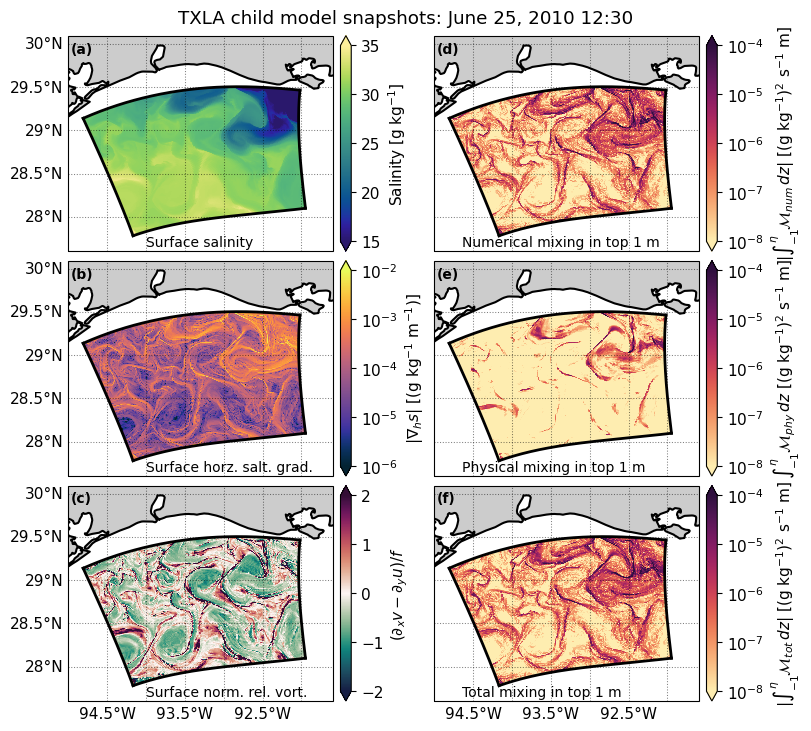

In [8]:
plt.rcParams.update({'font.size': 11})
ncols = 2;nrows = 3
fig,ax = plt.subplots(nrows,ncols,figsize=(8,(12/5)*3), subplot_kw={'projection': crs}, constrained_layout = True)

mappable = ax[0,0].pcolormesh(dsc.lon_rho,
                               dsc.lat_rho,
                               sss_c, 
                               cmap = cmo.haline,
                               vmin = 15,
                               vmax = 35,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable, ax = ax[0,0], orientation = 'vertical', 
                  extend = 'both', pad = 0.03)
cb.set_label(r'Salinity [g kg$^{-1}$]')

mappable1 = ax[0,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mnum_c)), 
                               cmap = cmo.matter,
                               vmin = -8,
                               vmax = -4,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable1, ax = ax[0,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.03, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'$|\int_{-1}^{\eta} \mathcal{M}_{num} \, dz|$ [(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')

mappable2 = ax[1,0].pcolormesh(dsc.lon_psi,
                            dsc.lat_psi,
                            np.log10(sgrad_c), 
                            cmap = cmo.thermal,
                            vmin = -6,
                            vmax = -2,
                            transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable2, ax = ax[1,0], orientation = 'vertical',  
                  ticks = [-6, -5, -4, -3, -2], format=tick.FormatStrFormatter('$10^{%d}$'),
                  extend = 'both', pad = 0.03)
cb.set_label(r'$|\nabla_h s|$ [(g kg$^{-1}$ m$^{-1}$)]')

mappable3 = ax[1,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mphy_c)), 
                               cmap = cmo.matter,
                               vmin = -8,
                               vmax = -4,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable3, ax = ax[1,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.03, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'$\int_{-1}^{\eta} \mathcal{M}_{phy} \, dz$ [(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')


mappable5 = ax[2,0].pcolormesh(dsc.lon_psi,
                             dsc.lat_psi,
                             rv_c, 
                             cmap = cmo.curl,
                             vmin = -2,
                             vmax = 2,
                             transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable5, ax = ax[2,0], orientation = 'vertical', 
                  extend = 'both', pad = 0.03)
cb.set_label(r'$(\partial_x v - \partial_y u)/f$')

mappable6 = ax[2,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mtot_c)), 
                               cmap = cmo.matter,
                               vmin = -8,
                               vmax = -4,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable6, ax = ax[2,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.03, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'$|\int_{-1}^\eta \mathcal{M}_{tot} \, dz|$ [(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')

for i in range(nrows):
    for j in range(ncols):
        ax[i,j].set_extent([-95, -91.6, 27.6, 30.1], ccrs.PlateCarree())
        ax[i,j].add_feature(land_10m, facecolor='0.8')
        ax[i,j].coastlines(resolution='10m', linewidth = 1.5)  
        ax[i,j].set_aspect('auto')
        ax[i,j].plot(dsc.lon_rho[0,:], 
                     dsc.lat_rho[0,:], 
                     'k', lw=2,transform = ccrs.PlateCarree())
        ax[i,j].plot(dsc.lon_rho[:,0], 
                     dsc.lat_rho[:,0], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
        ax[i,j].plot(dsc.lon_rho[:,-1], 
                     dsc.lat_rho[:,-1], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
        ax[i,j].plot(dsc.lon_rho[-1,:], 
                     dsc.lat_rho[-1,:], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
for i in range(nrows-1):
    gl = ax[i,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=False)
    gl = ax[i,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.left_labels = True
    gl.top_labels = False
    gl.bottom_labels = False

gl = ax[i+1,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

gl = ax[i+1,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False
gl.bottom_labels = True


ax[0,0].annotate('(a)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[0,0].annotate('Surface salinity', xy = (-94.0, 27.65), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 10)
ax[1,0].annotate('(b)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[1,0].annotate('Surface horz. salt. grad.', xy = (-94.0, 27.65), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 10)
ax[0,1].annotate('(d)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[0,1].annotate('Numerical mixing in top 1 m', xy = (-94.65, 27.65), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 10)
ax[1,1].annotate('(e)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[1,1].annotate('Physical mixing in top 1 m', xy = (-94.65, 27.65), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 10)
ax[2,0].annotate('(c)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[2,0].annotate('Surface norm. rel. vort.', xy = (-94.0, 27.65), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,0]),
                 color = 'k', fontsize = 10)
ax[2,1].annotate('(f)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[2,1].annotate('Total mixing in top 1 m', xy = (-94.65, 27.65), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,1]),
                 color = 'k', fontsize = 10)

# ax[0,0].annotate('', xy = (-92.6, 27.6), xytext = (-92.6, 27.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
#                  color = 'k', fontsize = 10, arrowprops = dict(facecolor = 'black', width = 2.5, headwidth = 8, headlength = 8), horizontalalignment='right')

fig.suptitle("TXLA child model snapshots: June 25, 2010 12:30")
fig.canvas.draw()
# plt.savefig('txla_mnum_overview.jpg', dpi = 600, bbox_inches='tight')

### Now modify for the manuscript. 
Have vorticity be the first plot, then salinity gradient magitude, then normalized FGF.Keep the mixing column the same 

/tmp/ipykernel_27831/3923602244.py:148: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.draw()


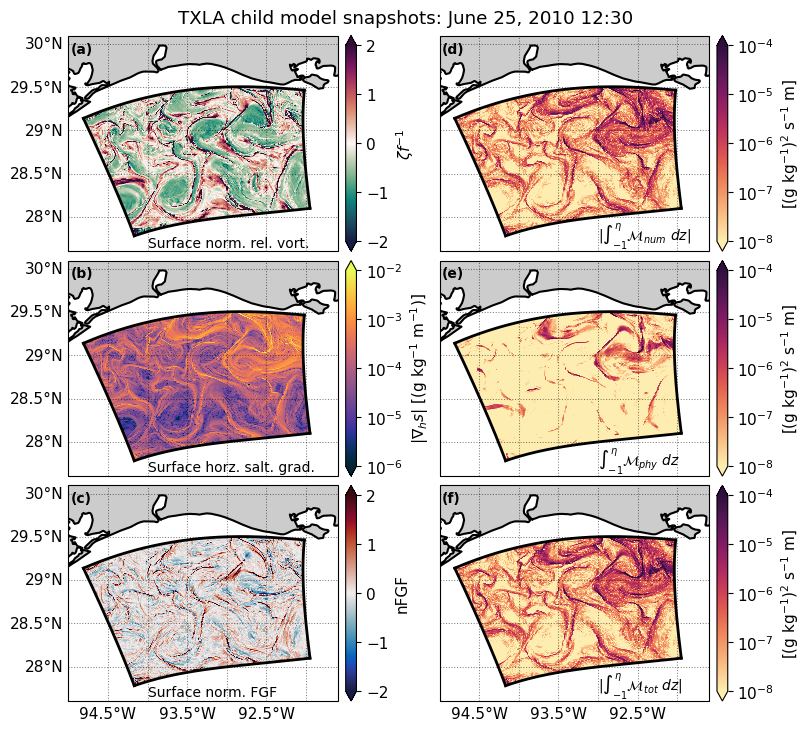

In [19]:
ncols = 2;nrows = 3
fig,ax = plt.subplots(nrows,ncols,figsize=(8,(12/5)*3), subplot_kw={'projection': crs}, constrained_layout = True)

mappable = ax[0,0].pcolormesh(dsc.lon_psi,
                              dsc.lat_psi,
                              rv_c, 
                              cmap = cmo.curl,
                              vmin = -2,
                              vmax = 2,
                              transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable, ax = ax[0,0], orientation = 'vertical', 
                  extend = 'both', pad = 0.03)
cb.set_label(r'$\zeta f^{-1}$')

mappable1 = ax[1,0].pcolormesh(dsc.lon_psi,
                            dsc.lat_psi,
                            np.log10(sgrad_c), 
                            cmap = cmo.thermal,
                            vmin = -6,
                            vmax = -2,
                            transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable1, ax = ax[1,0], orientation = 'vertical',  
                  ticks = [-6, -5, -4, -3, -2], format=tick.FormatStrFormatter('$10^{%d}$'),
                  extend = 'both', pad = 0.03)
cb.set_label(r'$|\nabla_h s|$ [(g kg$^{-1}$ m$^{-1}$)]')

mappable2 = ax[2,0].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               nfgf, 
                               cmap = cmo.balance,
                               vmin = -2,
                               vmax = 2,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable2, ax = ax[2,0], orientation = 'vertical', 
                  extend = 'both', pad = 0.03)
cb.set_label(r'nFGF')

mappable3 = ax[0,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mnum_c)), 
                               cmap = cmo.matter,
                               vmin = -8,
                               vmax = -4,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable3, ax = ax[0,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.03, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'[(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')


mappable4 = ax[1,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mphy_c)), 
                               cmap = cmo.matter,
                               vmin = -8,
                               vmax = -4,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable4, ax = ax[1,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.03, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'[(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')

mappable5 = ax[2,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mtot_c)), 
                               cmap = cmo.matter,
                               vmin = -8,
                               vmax = -4,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable5, ax = ax[2,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.03, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'[(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')

for i in range(nrows):
    for j in range(ncols):
        ax[i,j].set_extent([-95, -91.6, 27.6, 30.1], ccrs.PlateCarree())
        ax[i,j].add_feature(land_10m, facecolor='0.8')
        ax[i,j].coastlines(resolution='10m', linewidth = 1.5)  
        ax[i,j].set_aspect('auto')
        ax[i,j].plot(dsc.lon_rho[0,:], 
                     dsc.lat_rho[0,:], 
                     'k', lw=2,transform = ccrs.PlateCarree())
        ax[i,j].plot(dsc.lon_rho[:,0], 
                     dsc.lat_rho[:,0], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
        ax[i,j].plot(dsc.lon_rho[:,-1], 
                     dsc.lat_rho[:,-1], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
        ax[i,j].plot(dsc.lon_rho[-1,:], 
                     dsc.lat_rho[-1,:], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
for i in range(nrows-1):
    gl = ax[i,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=False)
    gl = ax[i,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.left_labels = True
    gl.top_labels = False
    gl.bottom_labels = False

gl = ax[i+1,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

gl = ax[i+1,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False
gl.bottom_labels = True

ax[0,0].annotate('(a)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[0,0].annotate('Surface norm. rel. vort.', xy = (-94.0, 27.65), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 10)
ax[1,0].annotate('(b)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[1,0].annotate('Surface horz. salt. grad.', xy = (-94.0, 27.65), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 10)
ax[0,1].annotate('(d)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[0,1].annotate(r'$\left|\int_{-1}^{\eta} \mathcal{M}_{num} \, \, dz \right|$', xy = (-93, 27.72), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 10)
ax[1,1].annotate('(e)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[1,1].annotate(r'$\int_{-1}^{\eta} \mathcal{M}_{phy} \, \, dz$', xy = (-93, 27.72), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 10)
ax[2,0].annotate('(c)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[2,0].annotate('Surface norm. FGF', xy = (-94.0, 27.65), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,0]),
                 color = 'k', fontsize = 10)
ax[2,1].annotate('(f)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[2,1].annotate(r'$\left|\int_{-1}^{\eta} \mathcal{M}_{tot} \, \, dz \right|$', xy = (-93, 27.72), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,1]),
                 color = 'k', fontsize = 10)

fig.suptitle("TXLA child model snapshots: June 25, 2010 12:30")
fig.canvas.draw()
plt.savefig('txla_mnum_surface.jpg', dpi = 600, bbox_inches='tight')

### Do a sensitivity study for the limits of integration. 
Test how the ratio of numerical to total mixing changes if integrated from -1 m to -2, -3, -5, and the whole water column 

In [20]:
mnum_c_psi = xroms.to_psi(dsc.dye_03*dsc.dz,gridc)
mnum_c = (mnum_c_psi.where(boxc).where(dsc.z_rho_psi>-2)).sum('s_rho').sel(ocean_time = model_time).load()

Akr_rho_c = gridc.interp(dsc.AKr,'Z')
mphy_c_psi = xroms.to_psi(Akr_rho_c*dsc.dz,gridc)
mphy_c = (mphy_c_psi.where(boxc).where(dsc.z_rho_psi>-2)).sum('s_rho').sel(ocean_time = model_time).load()

mtot_c = mnum_c+mphy_c

print(mnum_c.isel(eta_v = etaslice, xi_u = xislice).sum().values/(mtot_c.isel(eta_v = etaslice, xi_u = xislice).sum().values))

0.5121367910305307


In [21]:
mnum_c_psi = xroms.to_psi(dsc.dye_03*dsc.dz,gridc)
mnum_c = (mnum_c_psi.where(boxc).where(dsc.z_rho_psi>-3)).sum('s_rho').sel(ocean_time = model_time).load()

Akr_rho_c = gridc.interp(dsc.AKr,'Z')
mphy_c_psi = xroms.to_psi(Akr_rho_c*dsc.dz,gridc)
mphy_c = (mphy_c_psi.where(boxc).where(dsc.z_rho_psi>-3)).sum('s_rho').sel(ocean_time = model_time).load()

mtot_c = mnum_c+mphy_c

print(mnum_c.isel(eta_v = etaslice, xi_u = xislice).sum().values/(mtot_c.isel(eta_v = etaslice, xi_u = xislice).sum().values))

0.47230701375028605


In [22]:
mnum_c_psi = xroms.to_psi(dsc.dye_03*dsc.dz,gridc)
mnum_c = (mnum_c_psi.where(boxc).where(dsc.z_rho_psi>-5)).sum('s_rho').sel(ocean_time = model_time).load()

Akr_rho_c = gridc.interp(dsc.AKr,'Z')
mphy_c_psi = xroms.to_psi(Akr_rho_c*dsc.dz,gridc)
mphy_c = (mphy_c_psi.where(boxc).where(dsc.z_rho_psi>-5)).sum('s_rho').sel(ocean_time = model_time).load()

mtot_c = mnum_c+mphy_c

print(mnum_c.isel(eta_v = etaslice, xi_u = xislice).sum().values/(mtot_c.isel(eta_v = etaslice, xi_u = xislice).sum().values))

0.39966706765432786


#### Average over a week and check the entire water column. 
Comment these cells out because they will take a while to run if not on a computing cluster. Doubt a local machine can handle this

In [ ]:
%%time
model_time = slice('2010-6-20 12:30', '2010-6-27 12:30')

mnum_c_psi = xroms.to_psi(dsc.dye_03*dsc.dz,gridc)
mnum_c = mnum_c_psi.where(boxc).sum('s_rho').sel(ocean_time = model_time).load()

Akr_rho_c = gridc.interp(dsc.AKr,'Z')
mphy_c_psi = xroms.to_psi(Akr_rho_c*dsc.dz,gridc)
mphy_c = mphy_c_psi.where(boxc).sum('s_rho').sel(ocean_time = model_time).load()

mtot_c = mnum_c+mphy_c

print(mnum_c.isel(eta_v = etaslice, xi_u = xislice).sum().values/(mtot_c.isel(eta_v = etaslice, xi_u = xislice).sum().values))

0.2247837077471069
CPU times: user 3min 42s, sys: 4min 5s, total: 7min 47s
Wall time: 2min 39s


### Takes about 4 minutes to run on a 32 core cluster. Exceptionally slow! 

In [27]:
%%time
mnum_c_psi = xroms.to_psi(dsc.dye_03*dsc.dz,gridc)
mnum_c = (mnum_c_psi.where(boxc).where(dsc.z_rho_psi<-1)).sum('s_rho').sel(ocean_time = model_time).load()

Akr_rho_c = gridc.interp(dsc.AKr,'Z')
mphy_c_psi = xroms.to_psi(Akr_rho_c*dsc.dz,gridc)
mphy_c = (mphy_c_psi.where(boxc).where(dsc.z_rho_psi<-1)).sum('s_rho').sel(ocean_time = model_time).load()

mtot_c = mnum_c+mphy_c

print(mnum_c.isel(eta_v = etaslice, xi_u = xislice).sum().values/(mtot_c.isel(eta_v = etaslice, xi_u = xislice).sum().values))

0.18809564208386112
CPU times: user 5min 9s, sys: 6min 52s, total: 12min 2s
Wall time: 2min 28s


### Adding where makes it much slower unsurpsingly 

In [28]:
%%time
mnum_c_psi = xroms.to_psi(dsc.dye_03*dsc.dz,gridc)
mnum_c = (mnum_c_psi.where(boxc).where(dsc.z_rho_psi>-1)).sum('s_rho').sel(ocean_time = model_time).load()

Akr_rho_c = gridc.interp(dsc.AKr,'Z')
mphy_c_psi = xroms.to_psi(Akr_rho_c*dsc.dz,gridc)
mphy_c = (mphy_c_psi.where(boxc).where(dsc.z_rho_psi>-1)).sum('s_rho').sel(ocean_time = model_time).load()

mtot_c = mnum_c+mphy_c

print(mnum_c.isel(eta_v = etaslice, xi_u = xislice).sum().values/(mtot_c.isel(eta_v = etaslice, xi_u = xislice).sum().values))

0.49978704974081495
CPU times: user 5min 16s, sys: 7min 8s, total: 12min 24s
Wall time: 2min 31s


### In conclusion, the numerical mixing dominates in the top 1 m of the water column due to fronts, which have sharp lateral salinity gradients